In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import urllib
import string
import re
import nltk
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
tqdm.pandas()

In [2]:
train = pd.read_csv('dataset/train_data.csv')
# Drop the only entry which has neither "body" nor "title" in its webpageDescription
train.drop(index=2994, inplace=True)

test = pd.read_csv('dataset/test_data.csv')

merged_data = pd.concat([train, test], ignore_index=True)

# Convert webpageDescription from string to JSON
merged_data['webpageDescription'] = merged_data['webpageDescription'].apply(lambda x: json.loads(x))

### Fill webpageDescription using either title or body key

There are two approaches to use here for which there are two separate functions,

    - Fill all entries with body key and whereever body is None, fill it with title key => use_title_key()
    - Fill all entries with title key and whereever title is None, fill it with body key => use_body_key()

That's what the two functions listed here do and lambda function will apply it on the webpageDescription column

In [3]:
def use_title_key(x):
    # Some entries don't have title key, in that case add 'title' key with value as None
    # to avoid KeyError in the next if condition
    x.setdefault('title', None)
    
    if x['title'] == None:
        return x['body']
    
    return x['title']

def use_body_key(x):
    if x['body'] == None:
        return x['title']
    
    return x['body']

# COMMENT OR UNCOMMENT THESE LINES DEPENDING ON WHICH DATA YOU WANT IN THE webpageDescription column
# merged_data['webpageDescription'] = merged_data['webpageDescription'].apply(lambda x: use_title_key(x))
merged_data['webpageDescription'] = merged_data['webpageDescription'].apply(lambda x: use_body_key(x))
print(merged_data['webpageDescription'].isna().sum())

0


### Fill in ? values in the columns 

This can be changed as and when we determine new logic to fill in ? values

In [4]:
# Replace all ? values in isNews and isFrontPageNews by new category 'unknown'
merged_data['isNews'] = merged_data['isNews'].apply(lambda x: 'unknown' if x == '?' else x)
        
merged_data['isFrontPageNews'] = merged_data['isFrontPageNews'].apply(lambda x: 'unknown' if x == '?' else x)
    
# Assign all ? values in alchemy_category to "unknown" category
merged_data['alchemy_category'] = merged_data['alchemy_category'].apply(lambda x: 'unknown' if x == '?' else x)
    
# For all ? alchemy_category values we assigned them to "unknown" category
# and we are 100% confident of this assignment
# So we substitute alchemy_category_score = 1.0 (100%) for all ? values which correspond to 'unknown' category
merged_data['alchemy_category_score'] = merged_data['alchemy_category_score'].apply(lambda x: 1.0 if x == '?' else float(x))

### Adding website name feature

In [5]:
# Generate the websiteName feature
def generate_website_name(urls):
    websites = urls.apply(lambda x: urllib.parse.urlparse(x).netloc)

    # Only retain those website_names with atleast 30 entries, assign all other website names to 'other' general category
    websites_counts = websites.value_counts()
    websites_with_atleast_30 = list(websites_counts[websites_counts > 30].index)
    websites = websites.apply(lambda x: x if x in websites_with_atleast_30 else 'other')

    return websites

merged_data['websiteName'] = generate_website_name(merged_data['url'])

### Dropping redundant columns

    framebased because its all 0s
    url because after generating websiteName feature we can drop it
    others because they are highly correlated with other features in the dataset

In [6]:
merged_data.drop(['framebased', 'embedRatio', 'AvglinkWithTwoCommonWord', 'AvglinkWithThreeCommonWord', 'url'], axis=1, inplace=True)

### NLP Processing

Reference: https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words

In [14]:
def preprocess_webpage_description(description, lemmatize=False):
    # Function to convert a raw webpage description to a string of words
    # The input is a single string (webpage description), and 
    # the output is a single string (a preprocessed webpage description)

    # 1. Remove HTML
    words = BeautifulSoup(description).get_text() 

    # 2. Remove non-letters        
    words = re.sub("[^a-zA-Z]", " ", words) 

    # 3. Convert to lower case, split into individual words
    words = words.lower().split()                             
    
    # 4. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop words
    words = [w for w in words if not w in stops]   
    
    # 6. Stem or Lemmatize the words
    if lemmatize == False:
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]
    else:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    # 7. Join the words back into one string separated by space and return the result.
    return " ".join(words)


# Vectorize the webpageDescription data
# Specify the name of vectorizer as "tfidf" or "count" for CountVectorizer
# Can also pass in the maximum words to be retained in vocabulary, otherwise vectorizer will consider all the words in the vocabulary
# max_words_in_vocab=5000 will consider the 5000 most frequently occurring words in the dataset
def generate_vectorized_data(data_input, vectorizer_name='tfidf', lemmatize=True, max_words_in_vocab=None):
    
    data = data_input.copy(deep=True)
    
    print("Cleaning webpage description...")
    # Preprocess each description in the column according to the function described above
    data['webpageDescription'] = data['webpageDescription'].progress_apply(lambda x: preprocess_webpage_description(x, lemmatize))
    
    # Initialize vectorizer according to input parameters
    if vectorizer_name == "tfidf":
        vectorizer = TfidfVectorizer(max_features=max_words_in_vocab)
    elif vectorizer_name == "count":
        vectorizer = CountVectorizer(max_features=max_words_in_vocab)

    print("Applying vectorizer...")
    
    train_data = data[data['label'].isna() == False]
    test_data = data[data['label'].isna() == True]

    # Apply vectorizer to the data
    # Fit vectorizer on the train data and then fit it to the test data
    vectorized_train_data = vectorizer.fit_transform(train_data['webpageDescription']).toarray()
    vectorized_test_data = vectorizer.transform(test_data['webpageDescription']).toarray()
        
    vectorized_webpage_description = np.concatenate((vectorized_train_data, vectorized_test_data))
 
    # Converting data to a DataFrame so that it can be processed later more easily
    vectorized_webpage_description = pd.DataFrame(vectorized_webpage_description)
    print("Finished vectorization")
    
    return vectorized_webpage_description, vectorizer

### General Preprocessing

- Takes in features to use for training as input and selects them (id and label are always considered).
- Also takes in vectorized_data as NLP and concatenates it with the sliced data


### NOTE: For all functions that follow from here on, the features_to_use parameter is considered to determine which features to select and process for training
### features_to_use = [] => Use all features

In [8]:
def preprocessing(dataset_input, vectorized_data, features_to_use=[]):
    if features_to_use == []:
        features_to_use = dataset_input.columns
    
    # Required features that must always be present
    if 'id' not in features_to_use:
        features_to_use.append('id')
        
    if 'label' not in features_to_use:
        features_to_use.append('label')
    
    # Doing a copy so that the input dataset remains intact
    dataset = dataset_input.copy(deep=True)
    dataset = dataset[features_to_use]
    
    processed_data = pd.concat([dataset, vectorized_data], axis=1)
        
    return processed_data

### Train test split for regular training

This function does the following,
- Takes in the dataset as input which is the output of the preprocessing() function call
- Applies get_dummies on the categorical columns
- Removes webpageDescription & id from the data because they are not required for training
- Applies train_test_split with test_size = 0.3
- Applies StandardScaler by fitting on X_train and transforming both X_train & X_test
- Returns X_train, X_test, y_train, y_test

In [9]:
def preparing_data_for_training(dataset, random_state=42):
    train_data = dataset[dataset['label'].isna() == False]
    
    cur_dataset = train_data.copy(deep=True)
    
    temp_numeric_features = ['alchemy_category_score', 'avgLinkWordLength', 'AvglinkWithOneCommonWord',
                          'AvglinkWithFourCommonWord', 'redundancyMeasure', 'frameTagRatio',
                          'tagRatio', 'imageTagRatio', 'hyperlinkToAllWordsRatio',
                          'alphanumCharCount', 'linksCount', 'wordCount',
                          'parametrizedLinkRatio', 'spellingErrorsRatio'
                         ]
    numeric_features = []
    
    temp_cat_features = ['alchemy_category', 'domainLink', 'isNews', 'isFrontPageNews', 'lengthyDomain', 'websiteName']
    cat_features = []
    
    # Only consider those numeric and categorical features which are actually present in the dataset, i.e. being used for training
    for feature in cur_dataset.columns:
        if feature in temp_cat_features:
            cat_features.append(feature)
        elif feature in temp_numeric_features:
            numeric_features.append(feature)
    
    # Get dummies on categorical columns
    cur_dataset = pd.get_dummies(cur_dataset, columns=cat_features, drop_first=True)

    X = cur_dataset.drop(['label', 'webpageDescription', 'id'], axis=1)
    y = cur_dataset['label']
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        
    scaler = StandardScaler()
    
    # Standard Scaler requires us to save the changes in a copy instead of the original dataframe so that's why these copies are made
    X_train_copy = X_train.copy(deep=True)
    X_test_copy = X_test.copy(deep=True)
    
    scaler = StandardScaler()
    # Feature Standardization
    for feature in numeric_features:
        scaler.fit(X_train_copy[[feature]])
        X_train_copy[feature] = scaler.transform(X_train_copy[[feature]])
        X_test_copy[feature] = scaler.transform(X_test_copy[[feature]])
    
    return X_train_copy, X_test_copy, y_train, y_test

### Train-test Split for final submission

Very similar to the above function with the few changes being,
- There is no actual train_test_split() call here as we use the full train.csv data
- Apply get_dummies and feature standardization on the entire data (train.csv + test.csv)
- Separates out train.csv and test.csv data from this processed data
- Returns X_train (that has been processed from train.csv), y (from train.csv) & X_test (that has been processed from test.csv)

In [10]:
def preparing_data_for_final_submission(dataset):        
    cur_dataset = dataset.copy(deep=True)
    
    temp_numeric_features = ['alchemy_category_score', 'avgLinkWordLength', 'AvglinkWithOneCommonWord',
                          'AvglinkWithFourCommonWord', 'redundancyMeasure', 'frameTagRatio',
                          'tagRatio', 'imageTagRatio', 'hyperlinkToAllWordsRatio',
                          'alphanumCharCount', 'linksCount', 'wordCount',
                          'parametrizedLinkRatio', 'spellingErrorsRatio'
                         ]

    temp_cat_features = ['alchemy_category', 'domainLink', 'isNews', 'isFrontPageNews', 'lengthyDomain', 'websiteName']

    numeric_features = []
    cat_features = []
    
    # Only consider those numeric and categorical features which are actually present in the dataset
    for feature in cur_dataset.columns:
        if feature in temp_cat_features:
            cat_features.append(feature)
        elif feature in temp_numeric_features:
            numeric_features.append(feature)
    
    # Get dummies on categorical columns
    cur_dataset = pd.get_dummies(cur_dataset, columns=cat_features, drop_first=True)

    scaler = StandardScaler()
    
    # Feature Standardization
    for feature in numeric_features:
        cur_dataset[feature] = scaler.fit_transform(cur_dataset[[feature]])
    
    train_data = cur_dataset[cur_dataset['label'].isna() == False]
    test_data = cur_dataset[cur_dataset['label'].isna() == True]
    
    X_train = train_data.drop(['label', 'webpageDescription', 'id'], axis=1)
    y_train = train_data['label']
    # Do not drop "id" from X_test
    X_test = test_data.drop(['label', 'webpageDescription'], axis=1)
    
    return X_train, y_train, X_test

### Function that runs end-to-end to generate submission file

- If vectorized_data == None, then first calls nlp_preprocessing() using the given parameters (max_words_in_vocab, vectorizer_name) in function call.
- General preprocessing by calling preprocessing()
- Calls preparing_data_for_final_submission()
- Trains on the given model in function call
- Prepares the csv file to submit

In [15]:
# This is so that the function can be called separately when need be
def generate_csv_submission(test, y_final_pred, output_file_name='submission.csv'):
    # Preparing file to be submitted
    submission_df = pd.DataFrame()
    submission_df["id"] = test["id"]
    submission_df["label"] = y_final_pred
    submission_df.to_csv(output_file_name, index=False)

# features_to_use = None => Use all features
# vectorized_data = None => Vectorize the data using the vectorizer specified in the parameters
# If vectorized_data != None => max_words_in_vocab, vectorizer_name parameters are ignored
def end_to_end_run(data, model, vectorized_data=None, max_words_in_vocab=None, features_to_use=[], lemmatize=True, vectorizer_name='tfidf', output_file_name='submission.csv'):
    if vectorized_data == None:
        vectorized_data, _ = generate_vectorized_data(data, vectorizer_name, lemmatize, max_words_in_vocab)
    
    processed_data = preprocessing(data, vectorized_data, features_to_use)
    
    X_train_final, y_train_final, test = preparing_data_for_final_submission(processed_data)
    model.fit(X_train_final, y_train_final)

    # Drop 'id' before sending for training
    y_final_pred = model.predict(test.drop('id', axis=1))
    
    generate_csv_submission(test, y_final_pred, output_file_name)

### Example use-case of preparing_data_for_training() for model training

In [61]:
vectorized_data, vectorizer = generate_vectorized_data(merged_data, lemmatize=False, max_words_in_vocab=10000, vectorizer_name='tfidf')

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:28<00:00, 256.98it/s]


Applying vectorizer...
Finished vectorization


In [55]:
processed_data = preprocessing(merged_data, vectorized_data, features_to_use=[])

X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

In [56]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(roc_auc_score(y_test, y_pred))

0.7983949805371394


### Example use-case of creating final submission using preparing_data_for_final_submission()

In [57]:
X_train_final, y_train_final, test = preparing_data_for_final_submission(processed_data)

In [58]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train_final, y_train_final)

# Drop 'id' before sending for training
y_final_pred = model.predict(test.drop('id', axis=1))

generate_csv_submission(test, y_final_pred, 'test_submission_1.csv')

### Example use-case of end_to_end_run() to create submission file

In [45]:
model = LogisticRegression(max_iter=2000)

end_to_end_run(merged_data, model, max_words_in_vocab=10000, features_to_use=[], vectorizer_name='tfidf', output_file_name='test_submission_2.csv')

Cleaning webpage description...


100%|████████████████████████████████████| 7394/7394 [00:00<00:00, 10374.00it/s]


Applying vectorizer...
Finished vectorization


### Using only the webpageDescription column for submission

In [32]:
model = LogisticRegression(max_iter=2000)

end_to_end_run(data=merged_data, max_words_in_vocab=10000, model=model, features_to_use=['webpageDescription'], vectorizer_name='tfidf', output_file_name='test_submission_3.csv')

Cleaning webpage description...


100%|█████████████████████████████████████| 7394/7394 [00:01<00:00, 6333.87it/s]


Applying vectorizer...
Finished vectorization


### Using KNN Classifier

Spoiler Alert: It sucks ^_^

In [25]:
# roc_scores = []
# vectorized_data = generate_vectorized_data(merged_data['webpageDescription'], lemmatize=False, max_words_in_vocab=10000, vectorizer_name='tfidf')
# processed_data = preprocessing(merged_data, vectorized_data, features_to_use=['webpageDescription'])
# X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

# for k in range(5, 100):
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     roc_scores.append(roc_auc_score(y_test, y_pred))

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:28<00:00, 260.54it/s]


Applying vectorizer...
Finished vectorization


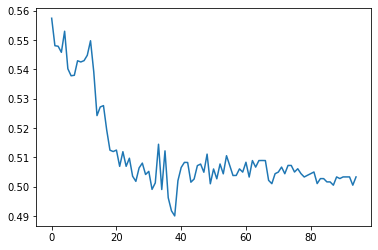

In [26]:
# plt.plot(roc_scores)

### Computing Probability Scores instead of predicting class labels

In [62]:
vectorized_data, vectorizer = generate_vectorized_data(merged_data, lemmatize=False, max_words_in_vocab=10000, vectorizer_name='tfidf')

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:29<00:00, 254.22it/s]


Applying vectorizer...
Finished vectorization


In [63]:
processed_data = preprocessing(merged_data, vectorized_data, features_to_use=['webpageDescription'])

X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

In [71]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_test, y_pred_proba))

0.8632515038329014


In [73]:
X_train_final, y_train_final, test = preparing_data_for_final_submission(processed_data)

model = LogisticRegression(max_iter=2000)
model.fit(X_train_final, y_train_final)

# Drop 'id' before sending for training
y_final_pred_proba = model.predict_proba(test.drop('id', axis=1))[:, 1]

generate_csv_submission(test, y_final_pred_proba, 'proba_scores_submission.csv')

### Applying Chi-Squared test to pick most relevant words out of given data

In [17]:
vectorized_data, vectorizer = generate_vectorized_data(merged_data, lemmatize=False, max_words_in_vocab=40000, vectorizer_name='tfidf')

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:28<00:00, 259.35it/s]


Applying vectorizer...
Finished vectorization


In [21]:
processed_data = preprocessing(merged_data, vectorized_data, features_to_use=['webpageDescription'])

X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

In [41]:
vocab_words = vectorizer.get_feature_names()

p_limit = 0.85

In [42]:
chi2_stats, p = chi2(X_train, y_train)

p_score_per_word = pd.DataFrame({"feature":vocab_words, "score":1-p})

p_score_per_word.sort_values('score', ascending=False)

,feature,score
26184,recip,1.0
8358,cup,1.0
3041,bake,1.0
6252,chees,1.0
5470,butter,1.0
...,...,...
39990,zwill,NaN
39991,zxiauljm,NaN
39992,zyban,NaN
39994,zyl,NaN


In [43]:
p_score_per_word_filtered = p_score_per_word[p_score_per_word['score'] > p_limit]

In [46]:
p_score_per_word_filtered

,feature,score
52,abc,0.872769
198,accessori,0.914413
371,ad,0.855025
379,adapt,0.876361
388,add,1.000000
...,...,...
39551,yolk,0.928734
39563,york,0.915102
39603,youtub,0.872897
39786,zest,0.976928


In [45]:
filtered_words = p_score_per_word_filtered["feature"].unique().tolist()

In [48]:
new_vectorizer = TfidfVectorizer(vocabulary=filtered_words)

train_data = merged_data[merged_data['label'].isna() == False]
X = train_data['webpageDescription']
y = train_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = new_vectorizer.fit_transform(X_train)
X_test = new_vectorizer.transform(X_test)

In [50]:
X_train.shape

(4140, 599)

<AxesSubplot:>

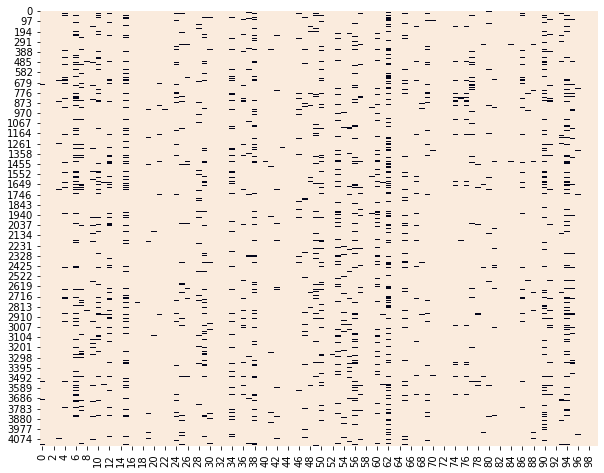

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=None)

In [59]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(roc_auc_score(y_test, y_pred))

0.7718582887700535


In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(roc_auc_score(y_test, y_pred))